In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states, run_field_scan
from quantum_tunneling.fields import apply_field, barrier_top


import matplotlib.animation as animation

In [2]:
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 5.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"
state_index = 0
F_grid = np.linspace(0.8, 2, 20)
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": 30.0, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
}
cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 5.0, 'alpha': 0.5}},
 'grid': {'L': 30.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0}}

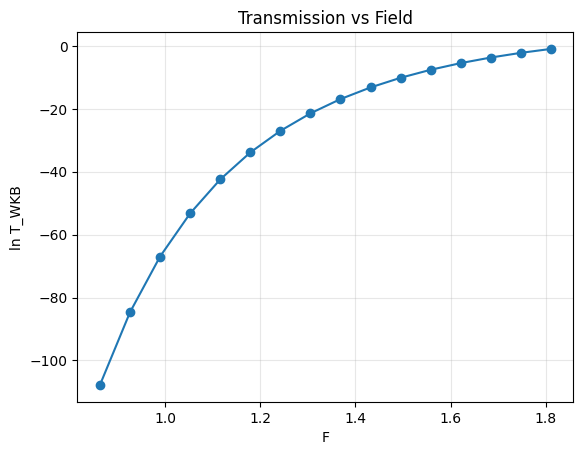

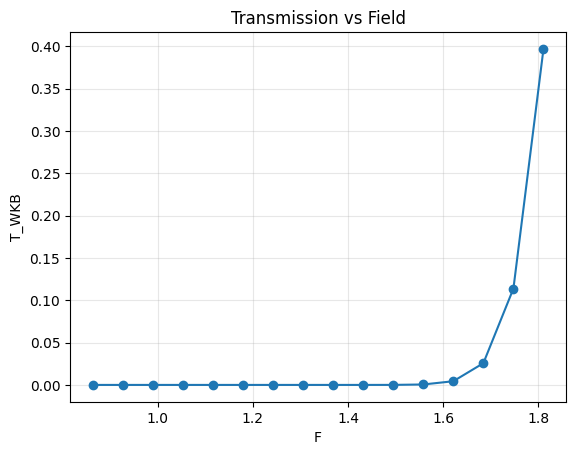

{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (-20.208159866777684, 38.64327135570872), 'F': 0.8}
{'status': 'can_tunnel(3.3490 < 41.8919, Tunneling Points: 0.5978 to 25.1980)', 'barrier': True, 'barrier_top': (-21.60699417152373, 41.891909638672516), 'turning_points': (0.5977646435118951, 25.197977553611793), 'S': 53.891785065480306, 'T_wkb': 1.5494952608829874e-47, 'F': 0.8631578947368421}
{'status': 'can_tunnel(3.3490 < 44.8584, Tunneling Points: 0.6142 to 21.2908)', 'barrier': True, 'barrier_top': (-22.70607826810991, 44.858446487338746), 'turning_points': (0.6141563129216328, 21.290827867591176), 'S': 42.32899528297086, 'T_wkb': 1.7119924622833348e-37, 'F': 0.9263157894736842}
{'status': 'can_tunnel(3.3490 < 47.6495, Tunneling Points: 0.6319 to 18.1338)', 'barrier': True, 'barrier_top': (-23.60532889258951, 47.64950953249645), 'turning_points': (0.6318918695997194, 18.133844542409868), 'S': 33.47241823511264, 'T_wkb': 8.437755351279772e-30, 'F': 0.98947368421052

In [5]:
res = run_bound_states(cfg)
scan = run_field_scan(cfg, res, state_index=state_index, F_grid=F_grid)
records = scan['records']
F_vals = [r['F'] for r in records]
T = [r['T_wkb'] if 'T_wkb' in r else np.nan for r in records]
lnT = np.log(T)
plt.figure()
plt.plot(F_vals, lnT, marker='o')
plt.xlabel('F')
plt.ylabel('ln T_WKB')
plt.title('Transmission vs Field')
plt.grid(True, alpha=0.3)
plt.savefig('transmission_vs_field_for_ground_state.png')
plt.figure()
plt.plot(F_vals, T, marker='o')
plt.xlabel('F')
plt.ylabel('T_WKB')
plt.title('Transmission vs Field')
plt.grid(True, alpha=0.3)
plt.show()


for r in records:
    print(r)

T_wkb都这么小。我觉得应该是m=1导致接近经典版本（毕竟经典隧穿概率为0）

不对应该不是，因为前面有个1/hbar

# How exotic barriers deform under tilting?
# 奇异势垒在倾斜下如何变形的？
我们对Vcusp施加一个线性外场F*x，扫描一系列场强F，然后创建势能图像的动画，这就能帮助我们理解势垒在外场下的变形情况。

0.8 9.76686094920899 7.812499968717335
0.8 9.76686094920899 7.812499968717335
0.8631578947368421 8.368026644462944 7.240842550792332
0.9263157894736842 7.268942547876769 6.747152003971951
0.9894736842105264 6.36969192339717 6.316481764718577
1.0526315789473686 5.620316402997503 5.9374807233351365
1.1157894736842104 5.020815986677768 5.601415068661592
1.1789473684210527 4.521232306411321 5.3012998547644266
1.2421052631578948 4.071606994171525 5.031747221007627
1.305263157894737 3.6719400499583656 4.7883053752157325
1.368421052631579 3.3222314737718577 4.567283275267406
1.431578947368421 3.0724396336386306 4.365748077271954
1.4947368421052634 2.7726894254787666 4.181256270371543
1.5578947368421052 2.5728559533721906 4.011823522812221
1.6210526315789475 2.3730224812656076 3.8555145386190777
1.6842105263157896 2.2231473771856756 3.7108630813831014
1.7473684210526317 2.0233139050790996 3.576687128071813
1.8105263157894738 1.923397169025808 3.451968570140444
1.8736842105263158 1.773522064945

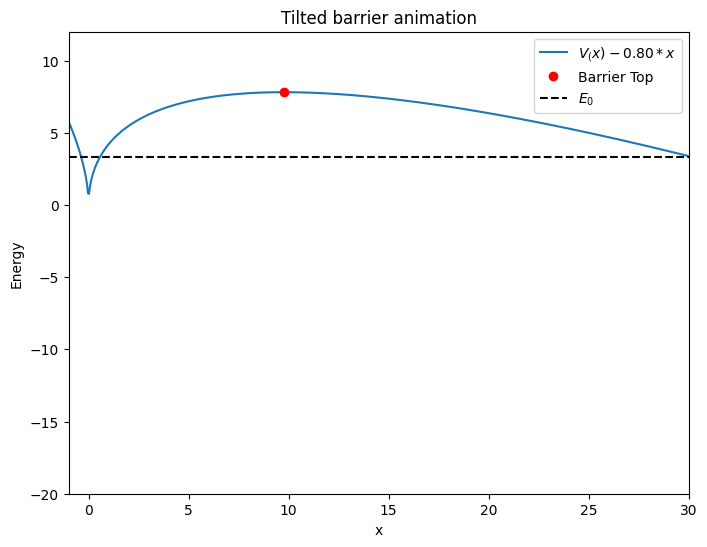

In [ ]:
# Visualize tilted barriers at a few F values.
'''sample_F = [F_vals[0], F_vals[len(F_vals)//2], F_vals[-1]]
x = res['x']
E = res['E'][state_index]
for F in sample_F:
    Vtilt = apply_field(res['Vx'], x, F)
    plt.figure()
    plt.plot(x, Vtilt, label=f'V-Fx (F={F:.2f})')
    plt.axhline(E, color='k', linestyle='--', label='E')
    plt.xlabel('x')
    plt.ylabel('Energy')
    plt.legend()
    plt.title('Tilted barrier snapshot')
    plt.tight_layout()
    plt.show()
    '''
# Visualize tilted barriers as an animation over F values.
x = res['x']
E = res['E'][state_index]
fig, ax = plt.subplots(figsize=(8, 6))
def update(frame):
    ax.cla()
    ax.set_ylim(-20, 12)
    ax.set_xlim(-1, cfg["grid"]["L"])
    F = F_vals[frame]
    Vtilt = apply_field(res['Vx'], x, F)
    xtop, vtop, idx = barrier_top(x, Vtilt,x_min=0)
    print(F, xtop, vtop)
    ax.plot(x, Vtilt, label=f'$V_(x)-{F:.2f}*x$')
    ax.plot(xtop, vtop, 'ro', label='Barrier Top')
    ax.axhline(E, color='k', linestyle='--', label='$E_0$')
    ax.set_xlabel('x')
    ax.set_ylabel('Energy')
    ax.legend()
    ax.set_title('Tilted barrier animation')
ani = animation.FuncAnimation(fig, update, frames=len(F_vals), repeat=False)
ani.save('tilted_barrier_animation.gif', writer='pillow', fps=10)

# Discussion

![Transmission vs Field](transmission_vs_field_for_ground_state.png)
![Tilted Barrier Animation](tilted_barrier_animation.gif)

As the external field strength increases, the exotic barrier gradually tilts, lowering the barrier height on the right side. This results in a decrease in the action integral $S=\int_{x_1}^{x_2} \sqrt{2m(V(x)-E)}\,dx$ and a corresponding increase in the WKB transmission coefficient $T=\exp(-\frac{2}{\hbar}S)$. The turning points move closer together as the barrier becomes less pronounced, facilitating tunneling.

When the field strength reaches a critical value, the barrier top drops below the bound state energy level (ground state in this case). At this point, the concept of tunneling becomes less relevant, as the particle can effectively escape without tunneling.

In [11]:

def F_ionization(V0,alpha,En):
    b = 1 - alpha
    return alpha*(b**b*V0/(En**b))**(1/alpha)

print("Estimated ionization field:", F_ionization(5,0.5, res['E'][0]))

Estimated ionization field: 1.866251567603244


# Onset of over-the-barrier ionization

### Result

For tilt Vcusp, the onset of over-the-barrier escape occurs at $F_{ionization}(V_0, \alpha, E_n) = \alpha \left( \frac{(1-\alpha)^{(1-\alpha)} V_0}{ E_n^{(1-\alpha)}} \right)^{1/\alpha}$.

### Deduction

$$
V(x) = V_0 |x|^\alpha + F x
$$

We take the part that x>0 for simplicity. The barrier top occurs where the derivative is zero:

$$
\frac{dV}{dx} = \alpha V_0 x^{\alpha - 1} + F = 0
$$

Solving for x gives the barrier top position:

$$
x_{top} = \left(-\frac{F}{\alpha V_0}\right)^{\frac{1}{\alpha - 1}}
$$

Plugging this back into V(x) to find the barrier height, and setting it equal to the energy level E_n:

$$
V_{top} = V_0 \left(-\frac{F}{\alpha V_0}\right)^{\frac{\alpha}{\alpha - 1}} + F \left(-\frac{F}{\alpha V_0}\right)^{\frac{1}{\alpha - 1}} = E_n
$$

Solving this equation for F gives the ionization field strength:

$$
F_{ionization} = \alpha \left( \frac{(1-\alpha)^{(1-\alpha)} V_0}{ E_n^{(1-\alpha)}} \right)^{1/\alpha}
$$